# Сборный проект № 2

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

Шаг 1. Откройте файл с данными и изучите общую информацию

In [136]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sb
import scipy.stats as stats

In [137]:
# загружаем данные о событиях из CSV-файла в переменную 
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('logs_exp.csv', sep='\t')

In [138]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Шаг 2. Подготовьте данные
Замените названия столбцов на удобные для вас;
Проверьте пропуски и типы данных. Откорректируйте, если нужно;
Добавьте столбец даты и времени, а также отдельный столбец дат;

In [140]:
# заменим наименования столбцов
df.rename(columns = {'EventName':'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_timestamp', 'ExpId': 'group'}, inplace = True )

In [141]:
# проверим наличие пропущенных значений
df.isna().sum()

event_name         0
user_id            0
event_timestamp    0
group              0
dtype: int64

In [142]:
# проверим наличие явных дубликатов
print('Количество дубликатов в таблице:', df.duplicated().sum())

Количество дубликатов в таблице: 413


In [143]:
# посчитаем долю дубликатов в процентах
display(round(df.duplicated().sum()*100/len(df),2))

0.17

In [144]:
# удаляем дубликаты
df=df.drop_duplicates().reset_index(drop=True)

In [145]:
# приведем значения столбца event_timestamp к типу даты
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')

In [164]:
# добавим отдельный столбец дат
df['date'] = df['event_timestamp'].dt.strftime('%Y-%m-%d')
#dt.round('1D')

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   group            243713 non-null  int64         
 4   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


In [166]:
df.head()

,event_name,user_id,event_timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [174]:
# посмотрим уникальные названия событий
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Неявные дубликаты в датафрейме отсутствуют.

In [167]:
# проверим наличие пользователей, которые вошли в более, чем одну группу исследования
df.groupby('user_id').agg({'group': 'nunique'}).query('group > 1').count()


group    0
dtype: int64

In [168]:
# посмотрим, за какой период предоставлены данные
print('Данные о событиях за период с ',df['event_timestamp'].min(), ' по ', df['event_timestamp'].max())

Данные о событиях за период с  2019-07-25 04:43:36  по  2019-08-07 21:15:17


В ходе предобработки данных изменила наименования столбцов. Проведена проверка на наличие пропущенных значений: пропусков в датафрейме нет. Были выявлены и удалены 413 явных дубликатов. Изменила тип данных в столбце event_timestamp и добавила новый столбец, содержащий только дату события. Проверила пересечение групп: пользователей, вошедших в более чем одну группу, не обнаружено.
Итак, данные о событиях за период с 25.07.2019 по 07.08.2019 готовы к анализу.


Шаг 3. Изучите и проверьте данные
Сколько всего событий в логе?
Сколько всего пользователей в логе?
Сколько в среднем событий приходится на пользователя?
Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
Много ли событий и пользователей вы потеряли, отбросив старые данные?
Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [169]:
print('Общее количество событий в логе:', len(df))

Общее количество событий в логе: 243713


In [170]:
print('Количество уникальных пользователей в логе:', df['user_id'].nunique())

Количество уникальных пользователей в логе: 7551


In [171]:
print('В среднем на одного пользователя приходится', round(len(df)/df['user_id'].nunique(),0), 'событий')

В среднем на одного пользователя приходится 32.0 событий


Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [175]:
# сгруппируем данные по группам и датам совершения событий 
df_pivot = pd.pivot_table(df, index='date', columns='group', values='event_name', aggfunc='count').sort_values(by='date', ascending=True)
df_pivot.head()


group,246,247,248
date,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71


<Figure size 3000x500 with 0 Axes>

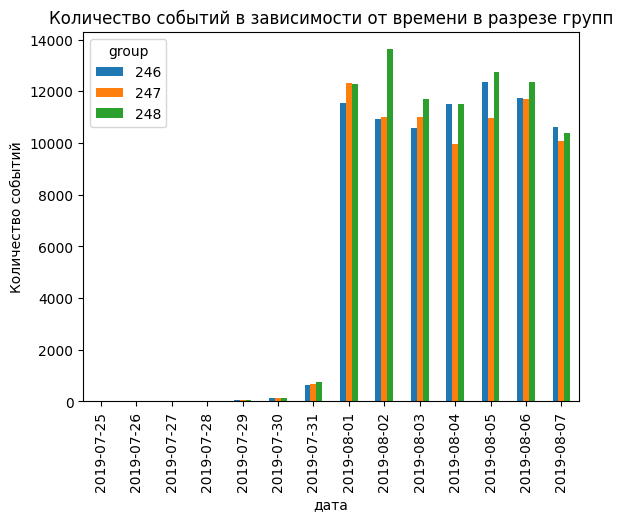

In [176]:
# построим столбчатую диаграмму
plt.figure(figsize=(30, 5))
df_pivot.plot.bar()
plt.locator_params (axis='x', nbins= 30)

plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.ylabel('Количество событий')
plt.xlabel('дата')
plt.show()

На диаграмме видно, что количество событий по 31.07.2019 очень мало. Это означает, что мы располагаем неполными данными за период с 25.07.2019 по 31.07.2019. Поэтому на самом деле мы располагаем полными данными о событиях за период с 01.08.2019 по 07.08.2019.


Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».

In [184]:
df_old = df[df['date'] <'2019-08-01']
df_old.head()

,event_name,user_id,event_timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [185]:
df_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2826 entries, 0 to 2825
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   event_name       2826 non-null   object        
 1   user_id          2826 non-null   int64         
 2   event_timestamp  2826 non-null   datetime64[ns]
 3   group            2826 non-null   int64         
 4   date             2826 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 132.5+ KB


In [186]:
# объявим переменную, содержащую список пользователей в "старых" данных и выведем их количество
old_users = df_old['user_id'].unique()
len(old_users)

1451

In [187]:
# отбросим "старые" данные
df_new = df.query('user_id not in @old_users').reset_index()

Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [191]:
print('количество событий, потерянных в результате отброса старых данных:',len(df) - len(df_new))

количество событий, потерянных в результате отброса старых данных: 60057
